# Sequence to Sequence

El modelo seq2seq (sequence-to-sequence) funciona mapeando una secuencia de entrada a otra secuencia de salida. Consta de dos partes principales: un codificador que procesa la secuencia de entrada y un decodificador que genera la secuencia de salida, utilizando la información de la secuencia codificada.

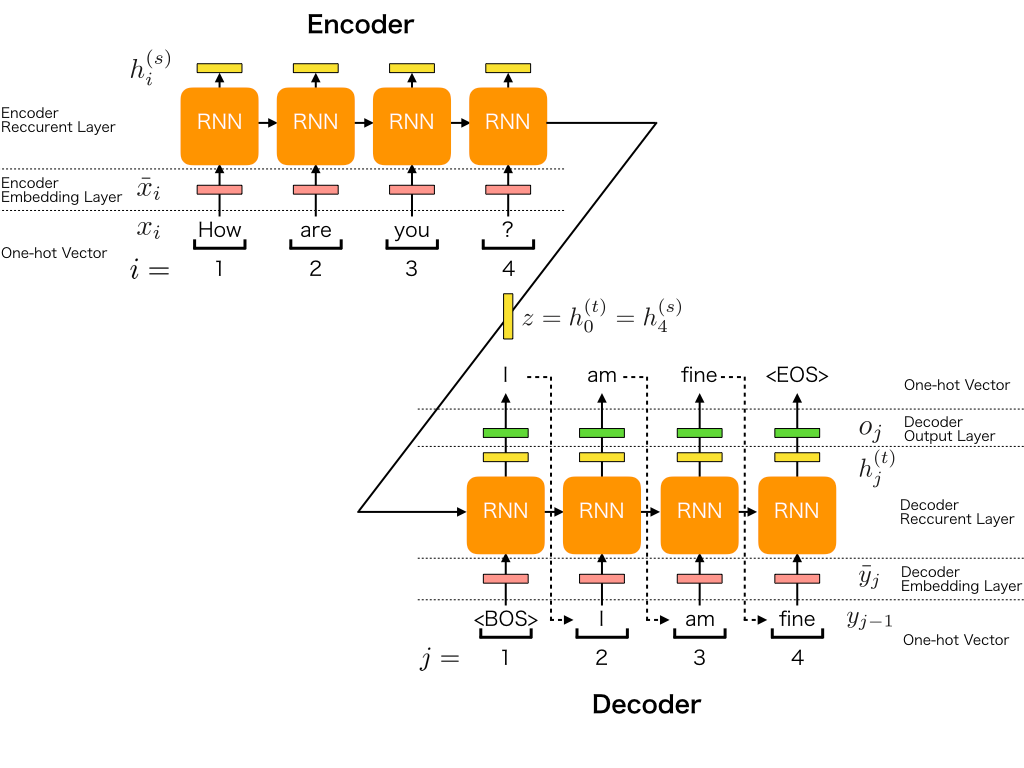

En un modelo seq2seq, el encoder y el decoder están estrechamente relacionados y funcionan de la siguiente manera:

**Encoder:**

- Toma la secuencia de entrada y la procesa paso a paso.
- A medida que procesa cada elemento de la secuencia, el encoder genera un vector de contexto (también llamado estado oculto), que resume la información relevante de la secuencia de entrada.
- Al final de la secuencia de entrada, el encoder produce un estado oculto final que representa toda la información capturada.

**Decoder:**

- Toma el vector de contexto proporcionado por el encoder como su entrada inicial.
- Genera la secuencia de salida paso a paso, utilizando el vector de contexto para guiar su generación.
- En cada paso, el decoder puede también considerar la salida generada en el paso anterior, lo que le permite mantener coherencia en la secuencia de salida.

La relación entre el encoder y el decoder es fundamental para que el modelo traduzca correctamente la información de la entrada a la salida. El vector de contexto actúa como un puente que conecta ambas partes, permitiendo que el decoder produzca secuencias que estén alineadas con la entrada procesada.

## Teacher Forcing

El teacher forcing es una técnica utilizada durante el entrenamiento de modelos secuenciales, como los seq2seq. En lugar de usar la predicción del modelo en cada paso para generar la siguiente entrada, se utiliza el valor correcto de la secuencia de salida (la "respuesta real"). Esto acelera el entrenamiento y ayuda al modelo a aprender más rápidamente, pero puede generar dependencia excesiva de las secuencias de entrenamiento, lo que a veces dificulta la predicción correcta en la inferencia cuando no tiene las respuestas reales.

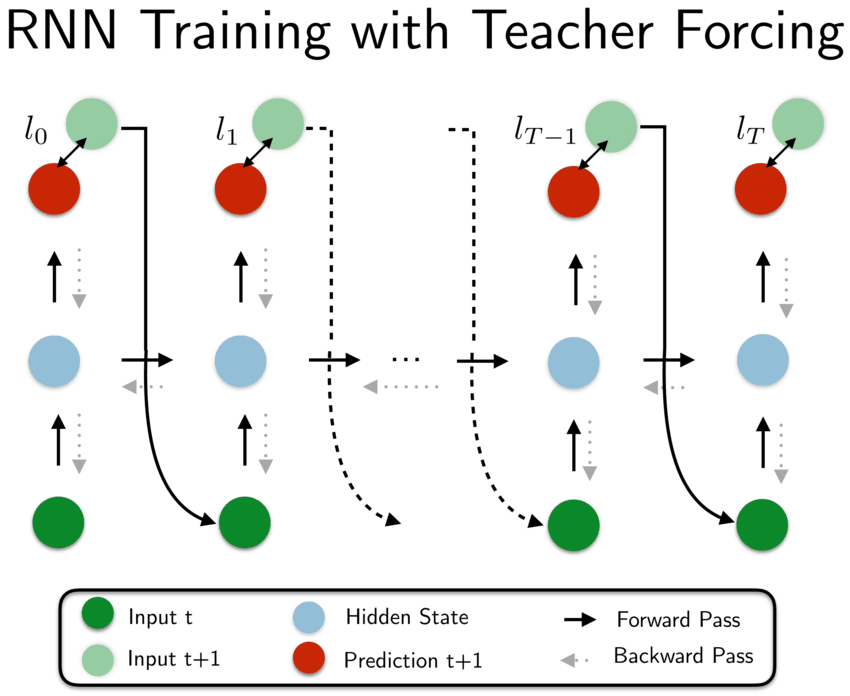

# Importing Libraries

In [ ]:
# !pip install torch==2.3.1 torchvision==0.18.1 torchaudio==2.3.1 --index-url https://download.pytorch.org/whl/cu121
# !pip install torchtext==0.18

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Disable tensorflow debugging logs
os.environ["KERAS_BACKEND"] = "torch"
import keras
import torch
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab as Vocab
from collections import Counter
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import optim
import time
torch.__version__, keras.__version__


/usr/local/lib/python3.10/dist-packages/torchtext/data/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/vocab/__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
/usr/local/lib/python3.10/dist-packages/torchtext/utils.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated

('2.3.1+cu121', '3.4.1')

In [3]:
torch.manual_seed(17)

# Processing Data

In [4]:
def process_text(paths):
    total_words = 0

    for path in paths:
        book = open(path, 'rb').read().decode(encoding='utf-8').lower()
        words = book.split()
        print(f'{path} - Words: {len(words)}')
        total_words += len(words)

    print(f'Total Words: {total_words}')

    # Extrae palabras y signos de puntuación de un texto.
    words = re.findall(r'\b\w+\b|[\.,;!?()"\']', book)

    # Genera pares de secuencias de palabras y sus subsecuencias para entrenamiento.
    maxlen = 32
    text_pairs = []
    for i in range(0, len(words), maxlen):
        inp = words[i:i + maxlen]
        out = words[i + maxlen :i + maxlen * 2]
        text_pairs.append((' '.join(inp), ' '.join(out)))
        for j in range(maxlen - 1):
            text_pairs.append((' '.join(inp[j + 1:]), ' '.join(out)))

    # Verificando cómo quedó text_pairs
    for i in range(5):
        print(text_pairs[i])

    return text_pairs

In [5]:
paths = ['./01 Harry Potter and the Sorcerers Stone.txt',
         './02 Harry Potter and the Chamber of Secrets.txt',
         './03 Harry Potter and the Prisoner of Azkaban.txt',
         './04 Harry Potter and the Goblet of Fire.txt',
         './05 Harry Potter and the Order of the Phoenix.txt',
         '06 Harry Potter and the Half-Blood Prince.txt',
         './07 Harry Potter and the Deathly Hallows.txt']
text_pairs = process_text(paths)

./01 Harry Potter and the Sorcerers Stone.txt - Words: 78431
./02 Harry Potter and the Chamber of Secrets.txt - Words: 86258
./03 Harry Potter and the Prisoner of Azkaban.txt - Words: 109563
./04 Harry Potter and the Goblet of Fire.txt - Words: 191798
./05 Harry Potter and the Order of the Phoenix.txt - Words: 261673
06 Harry Potter and the Half-Blood Prince.txt - Words: 173419
./07 Harry Potter and the Deathly Hallows.txt - Words: 200334
Total Words: 1101476
('the two men appeared out of nowhere , a few yards apart in the narrow , moonlit lane . for a second they stood quite still , wands directed at each other', "' s chests ; then , recognizing each other , they stowed their wands beneath their cloaks and started walking briskly in the same direction . news ? asked the taller of")
('two men appeared out of nowhere , a few yards apart in the narrow , moonlit lane . for a second they stood quite still , wands directed at each other', "' s chests ; then , recognizing each other , they s

# Pipeline

In [6]:
# !python -m spacy download en_core_web_sm
# Crea un tokenizador de spaCy en inglés.
eng_tokenizer = get_tokenizer('spacy', language='en_core_web_sm')

In [7]:
# Se construye un vocabulario a partir de un conjunto de texto, contando las frecuencias de las palabras y filtrando aquellas que no alcanzan un umbral mínimo

def build_vocab(text, tokenizers, min_freq=5):
    eng_tokenizer = tokenizers
    eng_counter = Counter()
    for eng_string_prev_, eng_string_post_ in text:
        eng_counter.update(eng_tokenizer(eng_string_prev_))
        eng_counter.update(eng_tokenizer(eng_string_post_))
    eng_vocab = Vocab(eng_counter, min_freq=min_freq, specials=['<unk>', '<pad>', '<bos>', '<eos>'])
    return eng_vocab

In [8]:
eng_vocab = build_vocab(text_pairs, eng_tokenizer, min_freq=0)

In [9]:
eng_vocab_size = len(eng_vocab)
eng_vocab_size

11138

In [10]:
# Convertir pares de texto en secuencias tensoriales de índices de vocabulario

def data_process(text,maxlen):
    data = []
    for eng_prev, eng_post in text:
        eng_prev_tensor_ = torch.tensor([eng_vocab[token] for token in eng_tokenizer(eng_prev)],
                                dtype=torch.long)
        eng_post_tensor_ = torch.tensor([eng_vocab[token] for token in eng_tokenizer(eng_post)],
                                dtype=torch.long)

        if eng_prev_tensor_.shape[0] < maxlen + 1:
            data.append((eng_prev_tensor_, eng_post_tensor_))
    return data

In [11]:
train_data = data_process(text_pairs, maxlen=32)

In [12]:
len(train_data)

239960

In [13]:
batch_size = 64
PAD_IDX = eng_vocab['<pad>']
BOS_IDX = eng_vocab['<bos>']
EOS_IDX = eng_vocab['<eos>']

In [14]:
# Organizar un lote de datos para el entrenamiento, agrega tokens de inicio y fin a las salidas, iguala las longitudes de las secuencias y devuelve las entradas y salidas ajustadas.

def generate_batch(data_batch):
    x, y = [], []
    for (x_item, y_item) in data_batch:
        x.append(x_item)
        y.append(torch.cat([torch.tensor([BOS_IDX]),
                            y_item,
                            torch.tensor([EOS_IDX])], dim=0))

    x = pad_sequence(x, batch_first=True, padding_value=PAD_IDX)
    y = pad_sequence(y, batch_first=True, padding_value=PAD_IDX)
    return x, y[:, :-1], y[:, 1:]

In [15]:
# Cargar y preprocesar los datos de entrenamiento en lotes

train_loader = DataLoader(train_data,
                        batch_size = batch_size,
                        shuffle = True,
                        collate_fn = generate_batch,
                        num_workers = 2,
                        pin_memory = True)

In [16]:
enc_batch, dec_batch, target_batch = next(iter(train_loader))

In [17]:
enc_batch.shape, dec_batch.shape, target_batch.shape

(torch.Size([64, 32]), torch.Size([64, 34]), torch.Size([64, 34]))

# Model Construction

In [18]:
emb_dim = 128
model_dim = 256

## Encoder

La clase Encoder implementa un modelo de codificación utilizando embeddings y una LSTM para procesar secuencias de texto, transformando entradas de palabras en vectores y produciendo estados ocultos para su uso en otras partes de un sistema de aprendizaje profundo.

In [19]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, model_dim=512):
        super(Encoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.LSTM(input_size=emb_dim,
                        hidden_size=model_dim,
                        num_layers=1,
                        batch_first=True)

    def forward(self, x):
        x = self.embedding(x)
        x, (hidden, cell) = self.rnn(x)
        return (hidden, cell)

In [20]:
encoder = Encoder(eng_vocab_size, emb_dim, model_dim)
state_batch = encoder(enc_batch)
state_batch[0].shape

torch.Size([1, 64, 256])

## Decoder

La clase Decoder implementa un modelo de decodificación que utiliza embeddings y una LSTM para generar secuencias, produciendo logits que representan la probabilidad de cada palabra en el vocabulario en base a la entrada y al estado previo del modelo.

In [21]:
class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_dim=256, model_dim=512):
        super(Decoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim)
        self.rnn = nn.LSTM(input_size=emb_dim,
                        hidden_size=model_dim,
                        num_layers=1,
                        batch_first=True)
        self.fc1 = nn.Linear(model_dim, vocab_size)

    def forward(self, x, state):
        x = self.embedding(x)
        x, (hidden, cell) = self.rnn(x, state)
        x = self.fc1(x)
        return x

In [22]:
decoder = Decoder(eng_vocab_size, emb_dim, model_dim)
output_batch = decoder(dec_batch, state_batch)
output_batch.shape, target_batch.shape

(torch.Size([64, 34, 11138]), torch.Size([64, 34]))

## seq2seq

La clase Seq2seq integra un encoder y un decoder en un único modelo, donde el encoder procesa la secuencia de entrada y produce un estado que el decoder utiliza para generar la secuencia de salida.

In [23]:
class Seq2seq(nn.Module):
    def __init__(self, encoder, decoder):
        super(Seq2seq, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, inp, tar):
        state = self.encoder(inp)
        x = self.decoder(tar, state)
        return x

In [24]:
seq2seq = Seq2seq(encoder, decoder)
output_batch = seq2seq(enc_batch, dec_batch)
output_batch.shape

torch.Size([64, 34, 11138])

# Training

In [25]:
loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

## train



In [26]:
def train(model, device, train_loader, optimizer, epoch):
    start = time.time()
    running_loss = 0.0
    model.train()
    for inp_enc, inp_dec, tar_dec in train_loader:
        tar_dec = tar_dec.reshape(-1)
        inp_enc = inp_enc.to(device)
        inp_dec = inp_dec.to(device)
        tar_dec = tar_dec.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inp_enc, inp_dec)
        outputs = outputs.view(-1, outputs.size(-1))
        loss = loss_fn(outputs, tar_dec)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f'\nTime for epoch {epoch} is {time.time()-start:.4f} sec Train loss: {running_loss / len(train_loader):.4f}')

## translate



In [27]:
def translate(model, sentence, device):
    with torch.no_grad():
        model.eval()
        eng_idx = torch.tensor([eng_vocab[token] for token in eng_tokenizer(sentence)],
                                    dtype=torch.long)
        eng_idx = eng_idx.reshape([1, -1])

        spa_idx = torch.tensor(BOS_IDX, dtype=torch.long)
        spa_idx = spa_idx.reshape([1, -1])

        while spa_idx[:, -1] != EOS_IDX:
            eng_idx = eng_idx.to(device)
            spa_idx = spa_idx.to(device)
            logits = model(eng_idx, spa_idx)[:, -1, :]
            probs = torch.softmax(logits, dim=-1)

            _, idx_next = torch.topk(probs, k=1, dim=-1)
            spa_idx = torch.cat((spa_idx, idx_next), dim=1)

        output = " ".join([eng_vocab.get_itos()[_] for _ in spa_idx[0]])
        output = output.replace("<bos>", "").replace("<eos>", "")
    print(f'Input: {sentence}')
    print(f'Output: {output}')

## Implementation

In [28]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [29]:
torch.cuda.is_available()

True

In [30]:
seq2seq.to(device)
optimizer = optim.Adam(seq2seq.parameters(), lr=0.001)

In [31]:
sentences = ['harry and hermione are dancing under the rain, when voldemort and dumbledore are fighting, then']

In [32]:
epochs = 15

for epoch in range(epochs):
    train(seq2seq, device, train_loader, optimizer, epoch)
    for s in sentences:
        translate(seq2seq, s, device)


Time for epoch 0 is 83.1068 sec Train loss: 4.3142
Input: harry and hermione are dancing under the rain, when voldemort and dumbledore are fighting, then
Output:  , said harry , and he was not sure that he had been a nightmarish experience , 

Time for epoch 1 is 83.7611 sec Train loss: 2.9596
Input: harry and hermione are dancing under the rain, when voldemort and dumbledore are fighting, then
Output:  a quarrel . . . . harry , ron , and hermione looked up at the 

Time for epoch 2 is 84.6667 sec Train loss: 2.1221
Input: harry and hermione are dancing under the rain, when voldemort and dumbledore are fighting, then
Output:  . the prisoners were still fixed upon the coiling serpent in its enchanted cage . the 

Time for epoch 3 is 84.1809 sec Train loss: 1.5227
Input: harry and hermione are dancing under the rain, when voldemort and dumbledore are fighting, then
Output:  . . . ron and hermione looked at each other , but there was no stopping it 

Time for epoch 4 is 84.0212 sec Train

## Word Embedding

In [97]:
words = 'magic kill good hate happy scared friend sad alive snape nagini voldemort harry ron hermione dumbledore cry hagrid lestrange sirius lupin luna'
words_ids = torch.tensor([eng_vocab[token] for token in eng_tokenizer(words)])
words_ids

tensor([ 997,  639,  109, 6417,  745, 4313,  568, 1326, 1919,   55, 1024,  353,
         370, 2545, 1093, 1281,  648, 1228, 6792, 1169,  856, 4811])

In [98]:
seq2seq.to('cpu')
seq2seq.eval()

Seq2seq(
  (encoder): Encoder(
    (embedding): Embedding(11138, 128)
    (rnn): LSTM(128, 256, batch_first=True)
  )
  (decoder): Decoder(
    (embedding): Embedding(11138, 128)
    (rnn): LSTM(128, 256, batch_first=True)
    (fc1): Linear(in_features=256, out_features=11138, bias=True)
  )
)

In [99]:
embeddings = seq2seq.encoder.embedding(words_ids).detach()
embeddings.shape

torch.Size([22, 128])

In [100]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA


# Perform PCA on embeddings
pca = PCA(n_components=2)
pca_embeddings = pca.fit_transform(embeddings)
print(pca_embeddings.shape)

(22, 2)


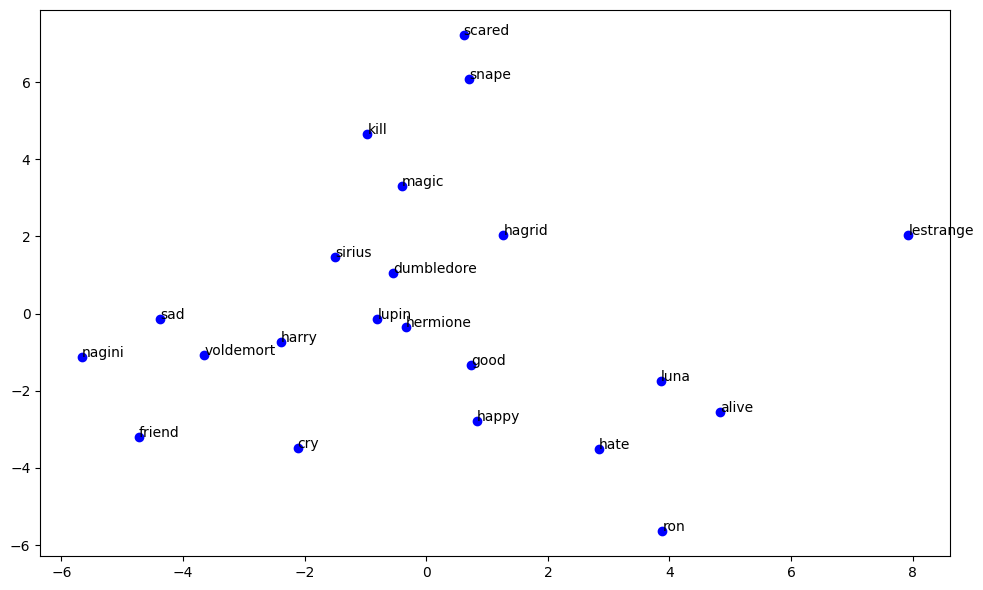

In [101]:
# Plot embeddings using matplotlib
fig, ax = plt.subplots()
fig.set_size_inches(10, 6)
ax.scatter(pca_embeddings[:, 0], pca_embeddings[:, 1], marker='o', c='b')

for i, word in enumerate(words.split()):
    ax.annotate(word, (pca_embeddings[i, 0], pca_embeddings[i, 1]))
plt.tight_layout()
plt.show()